In [1]:
import pandas as pd
import numpy as np
import torch
import utils.print as print_f
import os

from utils.engine import evaluate, get_iou_types
from utils.plot import plot_losses, plot_performance
from data.strs import TaskStrs, SourceStrs, FusionStrs

from models.utils import get_model_size_in_MB
from models.build import create_model_from_setup
from models.setup import ModelSetup
from models.train import TrainingInfo
from utils.save import check_best, end_train, get_data_from_metric_logger
from data.load import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.eval import get_ap_ar, get_ap_ar_for_train_val, get_performance
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup, get_coco_eval_params, get_dynamic_loss
from utils.init import reproducibility, clean_memory_get_device
from data.paths import MIMIC_EYE_PATH
# from datetime import datetime
# from models.dynamic_loss import DynamicWeightedLoss
from utils.engine import train_one_epoch, evaluate
from torch import optim
from models.setup import ModelSetup
from data.paths import MIMIC_EYE_PATH
# from data.load import seed_worker, get_dataloader_g

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore")

from models.components.task_performers import ObjectDetectionPerformer
from data.constants import DEFAULT_MIMIC_CLINICAL_NUM_COLS, DEFAULT_MIMIC_CLINICAL_CAT_COLS
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
# 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [3]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [4]:
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [5]:
# fix backbones
common_args_fix_backbones = {
    "decoder_channels": [128, 64, 32, 16, 8],
    "optimiser": "sgd",
    "lr": 1e-2,  # 1e-5,  # 1e-3 is a trainable value.
    "batch_size": 32,
    "sgb_momentum": 0.9,
    "weight_decay": 1e-5,  # 1e-5
    # "pretrained": True,
    "image_size": 512,
    "record_training_performance": False,
    "warmup_epochs": 0,
    "lr_scheduler": "ReduceLROnPlateau",  # ReduceLROnPlateau, MultiStepLR
    "reduceLROnPlateau_factor": 0.5,
    "reduceLROnPlateau_patience": 999,
    "reduceLROnPlateau_full_stop": False, # set to false to continue run.
    "multiStepLR_milestones": [20, 40, 60, 80, 100],  # list(range(1,100)),
    "multiStepLR_gamma": 0.5,
    "use_mask": False,
    "gt_in_train_till": 0,
    "box_head_dropout_rate": 0,
    "model_warmup_epochs": 999,  # stop fixing the weights in the backbone.
    "loss_warmup_epochs": 0,  # should be larger than model warm up.
    "measure_test": True,
    "use_dynamic_weight": True,
}

# no fix backbones
common_args_no_fix_backbones= {
    "decoder_channels": [128, 64, 32, 16, 8],
    "optimiser": "sgd",
    "lr": 1e-2,  # 1e-5,  # 1e-3 is a trainable value.
    "batch_size": 32,
    "sgb_momentum": 0.9,
    "weight_decay": 1e-5,  # 1e-5
    # "pretrained": True,
    "image_size": 512,
    "record_training_performance": False,
    "warmup_epochs": 0,
    "lr_scheduler": "ReduceLROnPlateau",  # ReduceLROnPlateau, MultiStepLR
    "reduceLROnPlateau_factor": 0.5,
    "reduceLROnPlateau_patience": 999,
    "reduceLROnPlateau_full_stop": False, # set to false to continue run.
    "multiStepLR_milestones": [20, 40, 60, 80, 100],  # list(range(1,100)),
    "multiStepLR_gamma": 0.5,
    "use_mask": False,
    "gt_in_train_till": 0,
    "box_head_dropout_rate": 0,
    "model_warmup_epochs": 0,  # stop fixing the weights in the backbone.
    "loss_warmup_epochs": 0,  # should be larger than model warm up.
    "measure_test": True,
    "use_dynamic_weight": True,
}


# lower lr
common_args_low_lr_with_fix_backbones = {
    "decoder_channels": [128, 64, 32, 16, 8],
    "optimiser": "sgd",
    "lr": 1e-3,  # 1e-5,  # 1e-3 is a trainable value.
    "batch_size": 32,
    "sgb_momentum": 0.9,
    "weight_decay": 1e-5,  # 1e-5
    # "pretrained": True,
    "image_size": 512,
    "record_training_performance": False,
    "warmup_epochs": 0,
    "lr_scheduler": "ReduceLROnPlateau",  # ReduceLROnPlateau, MultiStepLR
    "reduceLROnPlateau_factor": 0.5,
    "reduceLROnPlateau_patience": 999,
    "reduceLROnPlateau_full_stop": False, # set to false to continue run.
    "multiStepLR_milestones": [20, 40, 60, 80, 100],  # list(range(1,100)),
    "multiStepLR_gamma": 0.5,
    "use_mask": False,
    "gt_in_train_till": 0,
    "box_head_dropout_rate": 0,
    "model_warmup_epochs": 999,  # stop fixing the weights in the backbone.
    "loss_warmup_epochs": 0,  # should be larger than model warm up.
    "measure_test": True,
    "use_dynamic_weight": True,
}

# No dynamic weight
common_args_no_dynamic_weight_with_fix_backbones = {
    "decoder_channels": [128, 64, 32, 16, 8],
    "optimiser": "sgd",
    "lr": 1e-2,  # 1e-5,  # 1e-3 is a trainable value.
    "batch_size": 32,
    "sgb_momentum": 0.9,
    "weight_decay": 1e-5,  # 1e-5
    # "pretrained": True,
    "image_size": 512,
    "record_training_performance": False,
    "warmup_epochs": 0,
    "lr_scheduler": "ReduceLROnPlateau",  # ReduceLROnPlateau, MultiStepLR
    "reduceLROnPlateau_factor": 0.5,
    "reduceLROnPlateau_patience": 999,
    "reduceLROnPlateau_full_stop": False, # set to false to continue run.
    "multiStepLR_milestones": [20, 40, 60, 80, 100],  # list(range(1,100)),
    "multiStepLR_gamma": 0.5,
    "use_mask": False,
    "gt_in_train_till": 0,
    "box_head_dropout_rate": 0,
    "model_warmup_epochs": 999,  # stop fixing the weights in the backbone.
    "loss_warmup_epochs": 0,  # should be larger than model warm up.
    "measure_test": True,
    "use_dynamic_weight": False,
}

chexpert_best_args = {
    "performance_standard_task": TaskStrs.CHEXPERT_CLASSIFICATION,
    "performance_standard_metric": "auc",
}

lesion_detection_best_args = {
    "performance_standard_task": TaskStrs.LESION_DETECTION,
    "performance_standard_metric": "ap",
}

with_fix_args = {
    "sources": [SourceStrs.XRAYS, SourceStrs.FIXATIONS],
    # "sources": [SourceStrs.XRAYS, SourceStrs.CLINICAL,],
    "tasks": [
        TaskStrs.LESION_DETECTION,
        # TaskStrs.FIXATION_GENERATION,
        # TaskStrs.CHEXPERT_CLASSIFICATION,
        # TaskStrs.NEGBIO_CLASSIFICATION,
    ],
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

without_fix_args = {
    "sources": [SourceStrs.XRAYS],
    # "sources": [SourceStrs.XRAYS, SourceStrs.CLINICAL,],
    "tasks": [
        TaskStrs.LESION_DETECTION,
        # TaskStrs.FIXATION_GENERATION,
        # TaskStrs.CHEXPERT_CLASSIFICATION,
        # TaskStrs.NEGBIO_CLASSIFICATION,
    ],
    "fusor": FusionStrs.ElEMENTWISE_SUM,
}

small_model_args = {
    "mask_hidden_layers": 64,
    "fuse_conv_channels": 64,
    "representation_size": 64,  # 32
    # "clinical_input_channels": 64,
    # "clinical_conv_channels": 64,
    # "clinical_expand_conv_channels": 64,
    "backbone_out_channels": 64,
}

mobilenet_args = {
    "backbone": "mobilenet_v3",
    "using_fpn": False,
}

resnet_args = {
    "backbone": "resnet18",
    "using_fpn": False,
}

# "sources": [SourceStrs.XRAYS, SourceStrs.CLINICAL,],
# "tasks": [
#     # TaskStrs.LESION_DETECTION,
#     TaskStrs.FIXATION_GENERATION,
#     TaskStrs.CHEXPERT_CLASSIFICATION,
#     TaskStrs.NEGBIO_CLASSIFICATION,
# ],
# "performance_standard_task": TaskStrs.CHEXPERT_CLASSIFICATION,
# "performance_standard_metric": "auc",
# "performance_standard_task": TaskStrs.LESION_DETECTION,
# "performance_standard_metric": "ap",

In [6]:
all_model_setups = [
    ModelSetup(
        name="lesion_dsetection_with_fixation_input_fix_backbones",
        **lesion_detection_best_args,
        **resnet_args,
        **small_model_args,
        **common_args_fix_backbones,
        **with_fix_args
    ),

    ModelSetup(
        name="lesion_dsetection_with_fixation_input_no_fix_backbones",
        **lesion_detection_best_args,
        **resnet_args,
        **small_model_args,
        **common_args_no_fix_backbones,
        **with_fix_args
    ),

    ModelSetup(
        name="lesion_dsetection_with_fixation_input_low_lr_with_fix_backbones",
        **lesion_detection_best_args,
        **resnet_args,
        **small_model_args,
        **common_args_low_lr_with_fix_backbones,
        **with_fix_args
    ),
 
    ModelSetup(
        name="lesion_dsetection_with_fixation_input_no_dynamic_weight_with_fix_backbones",
        **lesion_detection_best_args,
        **resnet_args,
        **small_model_args,
        **common_args_no_dynamic_weight_with_fix_backbones,
        **with_fix_args
    ),

    ModelSetup(
        name="lesion_dsetection_with_fixation_input_mobilenet_with_fix_backbones",
        **lesion_detection_best_args,
        **mobilenet_args,
        **small_model_args,
        **common_args_fix_backbones,
        **with_fix_args
    ),
    # ModelSetup(
    #     name="lesion_detection_baseline",
    #     **lesion_detection_best_args,
    #     **resnet_args,
    #     **small_model_args,
    #     **common_args,
    #     **without_fix_args
    # ),
    
]

# pick the best one.

In [7]:
# train possible trainable arguement for the 

In [8]:
num_epochs = 30
train_infos: list[TrainingInfo] = []

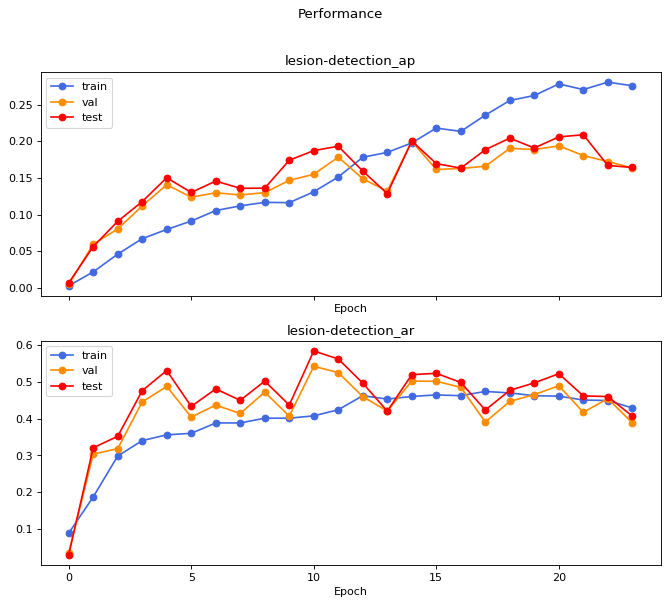

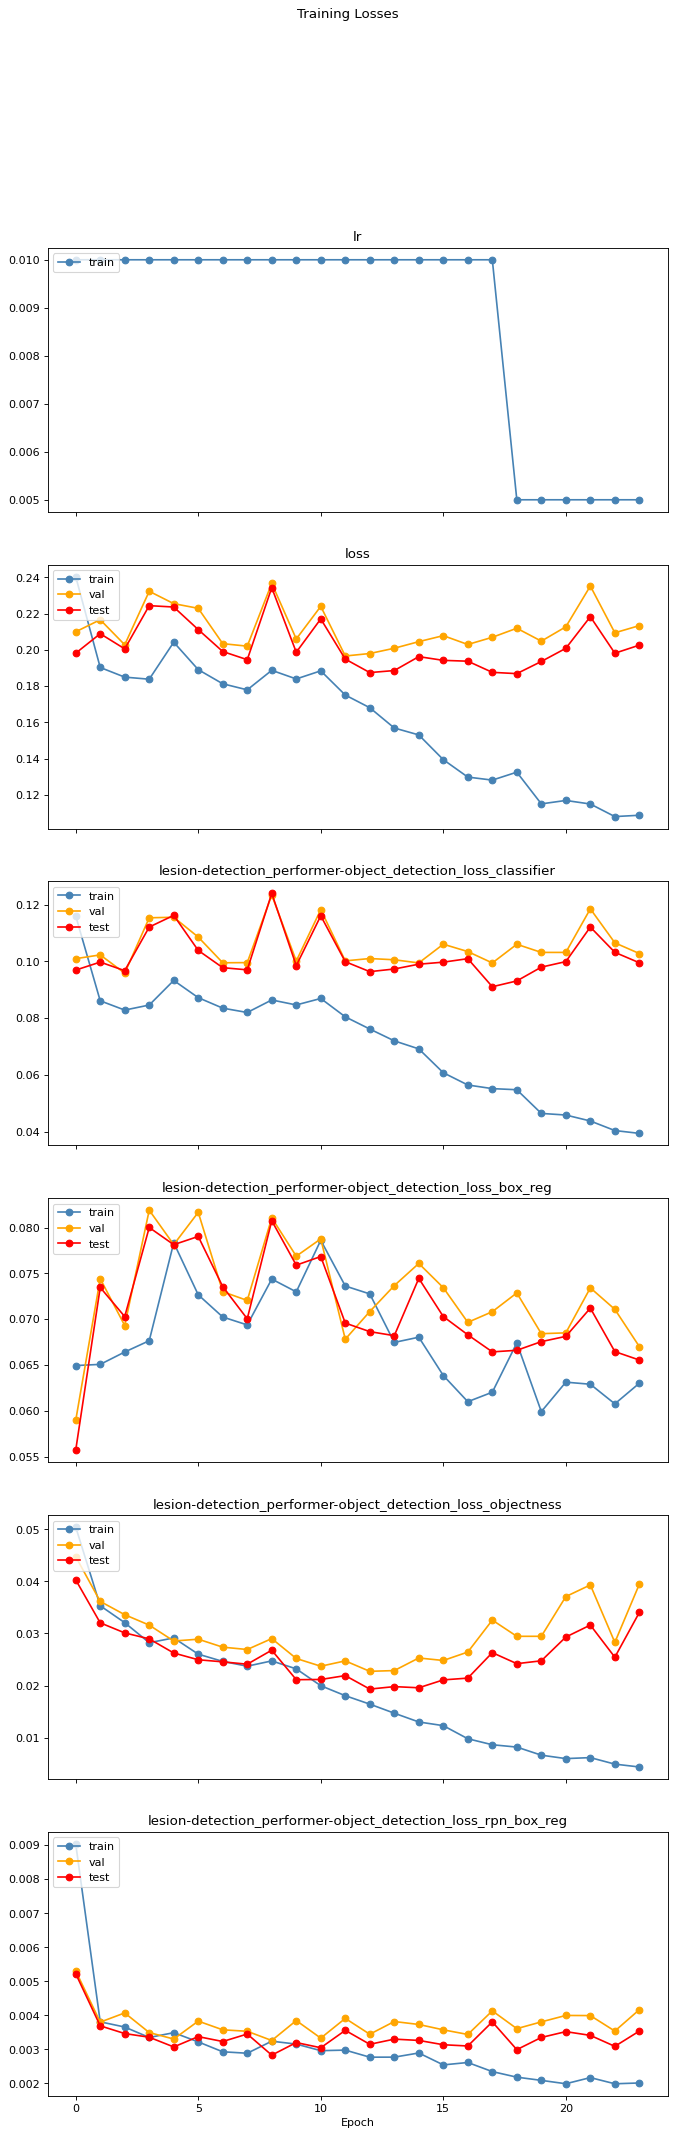

====================| Epoch [24] Done | It has took [259.30] min, Avg time: [648.25] sec/epoch | Estimate time for [200] epochs: [2160.83] min | Epoch took [633] sec | Patience [0] |====================
====================Training model: [lesion_dsetection_with_fixation_input]====================
========================================For Training [lesion_dsetection_with_fixation_input]========================================
ModelSetup(name='lesion_dsetection_with_fixation_input', sources=['xrays', 'fixations'], tasks=['lesion-detection'], fusor='element-wise sum', decoder_channels=[128, 64, 32, 16, 8], lesion_label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'], save_early_stop_model=True, record_training_performance=False, backbone='resnet18', optimiser='sgd', lr=0.01, weight_decay=1e-05, sgb_momentum=0.9, image_backbone_pretrained=True, heatmap_backbone_pretrained=False, image_size=512, image_mean=[0.485, 0.456, 0.40

KeyboardInterrupt: 

In [9]:
# we have to mention that in order to provide objective evaluation, we compromise the dataset size, which also nagatively afftect the performance and generlaization.
for setup in all_model_setups:
    assert (
        len(setup.sources) > 0 and len(setup.tasks) > 0
    ), "Need at least one source and task."

    print_f.print_title("Preparing for the training.")

    train_info = TrainingInfo(setup)

    model = create_model_from_setup(setup=setup)
    model = model.to(device)

    train_info.all_tasks = list(model.task_performers.keys())
    print(f" Model Size [{get_model_size_in_MB(model):.3f}] MB")

    ################ Datasets ################
    dataset_params_dict = {
        "MIMIC_EYE_PATH": MIMIC_EYE_PATH,
        "labels_cols": setup.lesion_label_cols,
        "with_xrays_input": SourceStrs.XRAYS in setup.sources,
        "with_clincal_input": SourceStrs.CLINICAL in setup.sources,
        "with_fixations_input": SourceStrs.FIXATIONS in setup.sources,
        "fiaxtions_mode_input": setup.fiaxtions_mode_input,
        "with_bboxes_label": TaskStrs.LESION_DETECTION in setup.tasks,
        "with_fixations_label": TaskStrs.FIXATION_GENERATION in setup.tasks,
        "fiaxtions_mode_label": setup.fiaxtions_mode_label,
        "with_chexpert_label": TaskStrs.CHEXPERT_CLASSIFICATION in setup.tasks,
        "with_negbio_label": TaskStrs.NEGBIO_CLASSIFICATION in setup.tasks,
        "clinical_numerical_cols": setup.clinical_num,
        "clinical_categorical_cols": setup.clinical_cat,
        "image_size": setup.image_size,
        "image_mean": setup.image_mean,
        "image_std": setup.image_std,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict,
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=setup.batch_size,
    )

    train_coco = None
    val_coco = None
    test_coco = None
    eval_params_dict = None

    if TaskStrs.LESION_DETECTION in setup.tasks:
        train_coco, val_coco, test_coco, eval_params_dict = get_coco_eval_params(
            source_name=SourceStrs.XRAYS,
            task_name=TaskStrs.LESION_DETECTION,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            detect_eval_dataset=detect_eval_dataset,
            iou_thrs=setup.iou_thrs,
            use_iobb=setup.use_iobb,
        )

    train_info.timer.start_training()


    dynamic_loss_weight = None
    if setup.use_dynamic_weight:
        dynamic_loss_weight = get_dynamic_loss(
            loss_keys=model.get_all_losses_keys(), device=device
        )
        
    params = model.get_all_params(dynamic_loss_weight=dynamic_loss_weight)

    iou_types = get_iou_types(model, setup)
    optimizer = get_optimiser(params, setup)
    lr_scheduler = get_lr_scheduler(optimizer, setup)

    print_f.print_title(
        f"Start training. Preparing Took [{train_info.timer.has_took_sec_from_init()}] sec"
    )

    train_info.timer.start_training()

    val_loss = None

    # Start the training from here.
    for e in range(1, num_epochs + 1):

        print_f.print_title(f"Training model: [{setup.name}]")

        print(train_info)
        if dynamic_loss_weight:
            for k,v  in dynamic_loss_weight.params.items():
                print(f"[{k}]: {v.item():.4f}")

        train_info.epoch = e

        train_info.timer.start_epoch()

        if (
            any(
                [
                    isinstance(p, ObjectDetectionPerformer)
                    for p in model.task_performers.values()
                ]
            )
            and train_info.epoch > setup.gt_in_train_till
        ):
            model.task_performers[
                TaskStrs.LESION_DETECTION
            ].roi_heads.use_gt_in_train = False

        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = train_one_epoch(
            setup=setup,
            model=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            # data_loader=test_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
            iou_types=iou_types,
            coco=train_coco,
            score_thres=None,
            evaluate_on_run=True,
            params_dict=eval_params_dict,
            dynamic_loss_weight=dynamic_loss_weight,
        )

        # train_info.train_evaluators.append(train_evaluator)
        train_info.train_losses.append(get_data_from_metric_logger(train_loger))
        ################################################################

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        train_info.last_val_evaluator, val_logger = evaluate(
            setup=setup,
            model=model,
            data_loader=val_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=val_coco,
            iou_types=iou_types,
            score_thres=None,
        )

        # train_info.val_evaluators.append(val_evaluator)
        train_info.val_losses.append(get_data_from_metric_logger(val_logger))

        train_info.performance["train"].append(
            get_performance(
                train_info.all_tasks,
                train_info.last_train_evaluator,
                iouThr=0.5,
                areaRng="all",
                maxDets=10,
            )
        )

        train_info.performance["val"].append(
            get_performance(
                train_info.all_tasks,
                train_info.last_val_evaluator,
                iouThr=0.5,
                areaRng="all",
                maxDets=10,
            )
        )

        if setup.measure_test:
            train_info.test_evaluator, test_logger = evaluate(
                setup=setup,
                model=model,
                data_loader=test_dataloader,
                device=device,
                params_dict=eval_params_dict,
                coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
            )
            train_info.test_losses.append(get_data_from_metric_logger(test_logger))

            train_info.performance["test"].append(
                get_performance(
                    train_info.all_tasks,
                    train_info.test_evaluator,
                    iouThr=0.5,
                    areaRng="all",
                    maxDets=10,
                )
            )

        # update the learning rate

        val_loss = train_info.val_losses[-1]["loss"]

        epoch_took, sec_already_took, speed = train_info.timer.end_epoch(
            train_info.epoch
        )

        if train_info.epoch > setup.warmup_epochs:
            if not lr_scheduler is None:
                if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    if (
                        setup.reduceLROnPlateau_full_stop
                        and lr_scheduler.num_bad_epochs
                        >= setup.reduceLROnPlateau_patience
                    ):
                        print_f.print_title(
                            f"| EarlyStop | Epoch [{train_info.epoch}] Done | It has took [{sec_already_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
                        )
                        break
                    lr_scheduler.step(val_loss)
                else:
                    lr_scheduler.step()

        # Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        # if model_setup.record_training_performance:
        # plot all matrics
        plot_performance(
            performance=train_info.performance,
            all_tasks=train_info.all_tasks,
            fig_title="Performance",
        )

        plot_losses(
            train_info.train_losses,
            train_info.val_losses,
            test_logers=train_info.test_losses,
        )

        print_str = f"| Epoch [{train_info.epoch}] Done | It has took [{sec_already_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec | "

        if lr_scheduler and hasattr(lr_scheduler, "num_bad_epochs"):
            print_str += f"Patience [{lr_scheduler.num_bad_epochs}] |"

        print_f.print_title(print_str)

        train_info

        #######################################################################################
        if setup.save_early_stop_model:
            val_performance_value, train_info = check_best(
                setup=setup,
                val_performance_value=train_info.performance["val"][-1][
                    setup.performance_standard_task
                ][setup.performance_standard_metric],
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
                dynamic_weight=dynamic_loss_weight,
            )
 
    train_info = end_train(
        setup=setup,
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_performance=train_info.performance["val"][-1][
            setup.performance_standard_task
        ][setup.performance_standard_metric],
        test_dataloader=test_dataloader,
        device=device,
        test_coco=test_coco,
        iou_types=iou_types,
        score_thres=None,
        dynamic_weight=dynamic_loss_weight,
    )

    train_infos.append(train_info)

# TODO: allow for any kind of pipeline.
## bb is not resized
#0.02?

In [ ]:
# import matplotlib.pyplot as plt
# # target_heatmap = model.evaluators['fixation-generation'].targets[0]['heatmaps'] 
# d_heatmap = train_dataset[0][1]['fixation-generation']['heatmaps']
# plt.imshow(d_heatmap.permute(1,2,0).to("cpu").numpy())
# plt.show()
# interpolated_heatmap = torch.nn.functional.interpolate(
#             d_heatmap[:, None].float(), size=(512, 512),
#         )[:, 0]
# plt.imshow((interpolated_heatmap/interpolated_heatmap.max()).permute(1,2,0).to("cpu").numpy())
# plt.show()
# transformed = model.task_performers[
#             TaskStrs.FIXATION_GENERATION
#         ].transform([train_dataset[0][0]['xrays']['images']], [train_dataset[0][1]])
# transform_heatmap = transformed[1][0]['fixation-generation']['heatmaps']
# plt.imshow(transform_heatmap.permute(1,2,0).to("cpu").numpy())
# plt.show()

In [10]:
for train_info in train_infos :
    print(train_info)
    plot_performance(
        performance=train_info.performance,
        all_tasks=train_info.all_tasks,
        fig_title="Performance",
    )
    plot_losses(
        train_info.train_losses,
        train_info.val_losses,
        test_logers=train_info.test_losses,
    )

In [11]:
print(train_info)

========================================For Training [lesion_dsetection_with_fixation_input]========================================
ModelSetup(name='lesion_dsetection_with_fixation_input', sources=['xrays', 'fixations'], tasks=['lesion-detection'], fusor='element-wise sum', decoder_channels=[128, 64, 32, 16, 8], lesion_label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'], save_early_stop_model=True, record_training_performance=False, backbone='resnet18', optimiser='sgd', lr=0.01, weight_decay=1e-05, sgb_momentum=0.9, image_backbone_pretrained=True, heatmap_backbone_pretrained=False, image_size=512, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225], backbone_out_channels=64, batch_size=32, warmup_epochs=0, model_warmup_epochs=10, loss_warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.5, reduceLROnPlateau_patience=5, reduceLROnPlateau_full_stop=False, multiStepLR_milestones=[20, 4

In [ ]:
# create the file to inspect the heatmap generated by the model.